In [51]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, split, when, countDistinct, max
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np

# create SparkSession
spark = SparkSession.builder \
    .appName("eCommerce_behavior_data_analysis") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.executor.heartbeatInterval", "900s") \
    .config("spark.network.timeout", "1000s") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

In [2]:
df = spark.read.csv("hdfs://localhost:9000/user/michaeliayang/2019-Oct.csv", header=True, inferSchema=True)

# Show first 5 lines
df.show(5)

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 02:00:00|      view|  44600062|2103807459595387724|                NULL|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 02:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 02:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    NULL|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 02:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 02:00:04|      view|   1004237|2053013555631882655|electr

In [3]:
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [4]:
missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
print('Missing Values:')
missing_values.show()

Missing Values:
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|     13515609|6113008|    0|      0|           2|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+



In [13]:
duplicates = df.groupBy(df.columns) \
    .count() \
    .filter(col("count") > 1)

duplicates_count = duplicates.count()

print(f"Number of Duplicates: {duplicates_count}")
duplicates.show(10)

Number of Duplicates: 18099
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+-----+
|         event_time|event_type|product_id|        category_id|       category_code|  brand| price|  user_id|        user_session|count|
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+-----+
|2019-10-01 16:44:59|      cart|   1801806|2053013554415534427|electronics.video.tv|  artel| 124.4|551484167|cbea1412-7f08-476...|    4|
|2019-10-01 10:32:16|      view|   2600519|2053013563970159485|                NULL| gefest|166.28|555549288|35785d30-1ba0-44b...|    2|
|2019-10-02 05:03:10|      cart|  30000074|2127425436764865054|construction.tool...|eurolux| 99.62|535333026|f492aac9-9ce1-4ba...|    2|
|2019-10-02 10:42:47|      cart|   1004767|2053013555631882655|electronics.smart...|samsung|253.05|543076049|5f099d9f-bd48-40d...|    2|
|2019-10-02 1

In [16]:
df = df.dropDuplicates()
duplicates = df.groupBy(df.columns) \
    .count() \
    .filter(col("count") > 1)

duplicates_count = duplicates.count()

print(f"Number of Duplicates: {duplicates_count}")

Number of Duplicates: 0


In [20]:
event_type = df.select('event_type').distinct()
event_type.show()

+----------+
|event_type|
+----------+
|  purchase|
|      view|
|      cart|
+----------+



# Global Convension Rate Analysis

In [19]:
# calculate the global conversion rate
global_funnel = df.groupBy("event_type").agg(count("*").alias("event_count"))

total_views = global_funnel.filter(col("event_type") == "view").select("event_count").collect()[0][0]
total_carts = global_funnel.filter(col("event_type") == "cart").select("event_count").collect()[0][0]
total_purchases = global_funnel.filter(col("event_type") == "purchase").select("event_count").collect()[0][0]

view_to_cart_rate = total_carts / total_views
cart_to_purchase_rate = total_purchases / total_carts
overall_conversion_rate = total_purchases / total_views

print(f"View to Cart Rate: {view_to_cart_rate:.2%}")
print(f"Cart to Purchase Rate: {cart_to_purchase_rate:.2%}")
print(f"Overall Conversion Rate: {overall_conversion_rate:.2%}")

View to Cart Rate: 2.20%
Cart to Purchase Rate: 82.67%
Overall Conversion Rate: 1.82%


# Category Convension Rate Analysis

In [23]:
df_categories = df.withColumn("category_main", split(col("category_code"), r"\.").getItem(0))
    
df_no_nulls = df_categories.filter(col("category_code").isNotNull())

# Check if main categories are correctly extracted
df_no_nulls.select("category_code", "category_main").show(10)

+--------------------+-------------+
|       category_code|category_main|
+--------------------+-------------+
|electronics.audio...|  electronics|
|construction.tool...| construction|
|electronics.smart...|  electronics|
|appliances.kitche...|   appliances|
|electronics.smart...|  electronics|
|electronics.smart...|  electronics|
|electronics.smart...|  electronics|
|electronics.smart...|  electronics|
|electronics.smart...|  electronics|
|  electronics.clocks|  electronics|
+--------------------+-------------+
only showing top 10 rows



In [45]:
category_main_count = df_no_nulls.groupBy("category_main").agg(countDistinct("product_id").alias("product_count"))
category_main_count.show()

# calculate total products
total_products = df_no_nulls.select(countDistinct("product_id")).collect()[0][0]

# calculate the ratio of each product
category_main_ratio = category_main_count.withColumn("product_ratio", col("product_count") / total_products)

category_main_ratio.show()

+-------------+-------------+
|category_main|product_count|
+-------------+-------------+
|     medicine|           29|
|    computers|         7930|
|         auto|         1201|
|   stationery|          607|
|        sport|         2157|
|      apparel|        13417|
|   appliances|        12362|
| country_yard|          185|
|    furniture|         6972|
|  accessories|         2516|
|         kids|         5123|
|  electronics|        14950|
| construction|         5701|
+-------------+-------------+

+-------------+-------------+--------------------+
|category_main|product_count|       product_ratio|
+-------------+-------------+--------------------+
|     medicine|           29|3.964456596035543...|
|    computers|         7930| 0.10840738209159262|
|         auto|         1201|0.016418318523581683|
|   stationery|          607|0.008298017771701981|
|        sport|         2157|0.029487354750512645|
|      apparel|        13417| 0.18341763499658237|
|   appliances|        12362| 

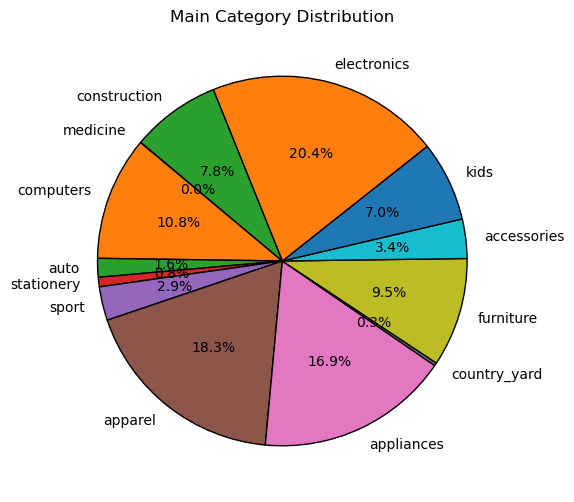

In [77]:
category_main_ratio_pd = category_main_ratio.toPandas()

mainCat_names = category_main_ratio_pd["category_main"]
mainCat_values = category_main_ratio_pd["product_ratio"]

plt.figure(figsize=(6, 6))
plt.pie(mainCat_values, labels=mainCat_names, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Main Category Distribution")
plt.show()

In [85]:
category_funnel = df_no_nulls.groupBy("category_main", "event_type").agg(countDistinct("product_id").alias("product_count"))
category_funnel.show(10)

window_spec = Window.partitionBy("category_main")
category_conversion = category_funnel.withColumn("total_views", sum(col("product_count")).over(window_spec)) \
    .filter(col("event_type") == "purchase") \
    .withColumn("conversion_rate", col("product_count") / col("total_views")) \
    .select("category_main", "conversion_rate")

category_conversion.show(10)

+-------------+----------+-------------+
|category_main|event_type|product_count|
+-------------+----------+-------------+
|   appliances|  purchase|         4838|
|   stationery|      cart|           34|
|        sport|  purchase|          270|
| construction|  purchase|          939|
|   appliances|      cart|         2852|
|         auto|      cart|          167|
|    furniture|      cart|          218|
|  accessories|  purchase|          554|
|  electronics|  purchase|         4698|
|    computers|      cart|         1285|
+-------------+----------+-------------+
only showing top 10 rows

+-------------+-------------------+
|category_main|    conversion_rate|
+-------------+-------------------+
|  accessories|0.17399497487437185|
|      apparel|0.15754154907494514|
|   appliances| 0.2412726910033912|
|         auto|0.30804248861911987|
|    computers|0.22255968953007677|
| construction| 0.1347782402755849|
| country_yard|0.13063063063063063|
|  electronics|0.21801475706529305|
|   

# The part below not done yet!

In [86]:
category_conversion = df_no_nulls.groupBy("category_main").agg(
    count(when(col("event_type") == "view", True)).alias("view_count"),
    count(when(col("event_type") == "purchase", True)).alias("purchase_count")
)

# calculate conversion ratio
category_conversion = category_conversion.withColumn(
    "conversion_rate", col("purchase_count") / col("view_count")
)

category_conversion.show()

+-------------+----------+--------------+--------------------+
|category_main|view_count|purchase_count|     conversion_rate|
+-------------+----------+--------------+--------------------+
|     medicine|     13974|           310|  0.0221840561041935|
|    computers|   2268793|         27853|0.012276571727786536|
|         auto|    993394|         10619|0.010689615600657947|
|   stationery|      7380|           134|0.018157181571815718|
|        sport|    174310|          1236|0.007090815214273...|
|      apparel|   1534873|          8002|0.005213460657657018|
|   appliances|   4799746|         74988|0.015623326734373028|
| country_yard|     13956|            72|0.005159071367153913|
|    furniture|   1236410|          8299|0.006712174764034584|
|  accessories|    236100|          1587|0.006721728081321474|
|         kids|    512465|          5482| 0.01069731591425756|
|  electronics|  15037384|        422979|0.028128496286322142|
| construction|    712672|          7801|0.010946129495

In [87]:
category_cart_conversion = df_no_nulls.groupBy("category_main").agg(
    count(when(col("event_type") == "cart", True)).alias("cart_count"),
    count(when(col("event_type") == "purchase", True)).alias("purchase_count")
)

category_cart_conversion = category_cart_conversion.withColumn(
    "cart_to_purchase_rate", col("purchase_count") / col("cart_count")
)

category_cart_conversion.show()

+-------------+----------+--------------+---------------------+
|category_main|cart_count|purchase_count|cart_to_purchase_rate|
+-------------+----------+--------------+---------------------+
|     medicine|       514|           310|    0.603112840466926|
|    computers|     26821|         27853|    1.038477312553596|
|         auto|      8916|         10619|   1.1910049349484073|
|   stationery|       106|           134|   1.2641509433962264|
|        sport|      1015|          1236|   1.2177339901477833|
|      apparel|        26|          8002|    307.7692307692308|
|   appliances|     89371|         74988|   0.8390641259468955|
| country_yard|        53|            72|   1.3584905660377358|
|    furniture|      2331|          8299|   3.5602745602745602|
|  accessories|       537|          1587|   2.9553072625698324|
|         kids|      2534|          5482|   2.1633780584056828|
|  electronics|    653158|        422979|   0.6475906289136778|
| construction|     10081|          7801